#Transfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model of your choice on a sub-dataset from the [MedMNIST datasets](https://medmnist.com/). ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook and/or in your final forum post.




# 1. Install & Import Packages

In [1]:
!pip install medmnist
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.2 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of input channels below that will affect your model)



In [3]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'pathmnist'
download = True

BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  9
The batch size for this dataset will be =  64


Transforms:
You can update the functions below with appropriate transforms for your particular use case.

* As well as being suitable for data augmention for image classification, the transforms.v2 package of torchvision extends transforms for object detection and segmentation tasks. An illustration of the transforms is shown [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).
* Normalisation based on ImageNet parameters is included already. This should be used with all models pre-trained on ImageNet  





In [4]:
# adding Data augmentation: RamdomHorizontal Flip and Random Rotation
train_transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image. However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, the gap between the original ImageNet domain and the medical images is wide. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.


In [5]:
# Download training data from open datasets.
train_dataset = DataClass(split='train', transform=train_transforms, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=test_transforms, download=download, size=224, mmap_mode='r')
val_dataset = DataClass(split='val', transform=test_transforms, download=download, size=224, mmap_mode='r')


100%|██████████| 12.6G/12.6G [14:32<00:00, 14.5MB/s]


The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [6]:
# Create data loaders.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 1]) torch.int64


Plot some example augmented images

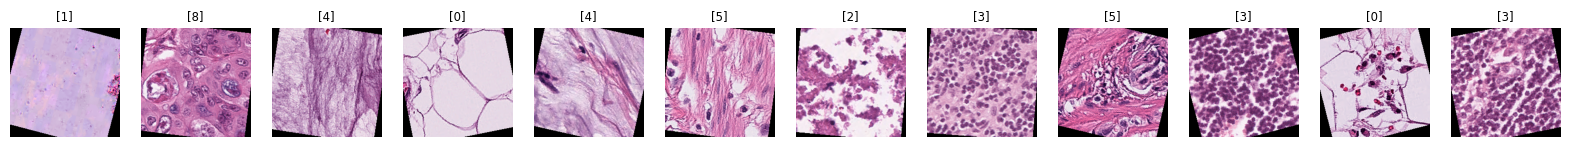

In [7]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1


# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

In [9]:
### Optimisation Setup ##

# Load pre-trained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer with 9 outputs (PathMNIST has 9 classes)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 9)   # 9 classes
)

# Move model to device
model = model.to(device)

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


In [10]:
## Training & Validation Loop##
def train_loop(dataloader, model, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y = torch.squeeze(y)  # ensure labels are [N]

        # Forward pass
        pred = model(X)
        loss = criterion(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(dataloader)
    acc = correct / total
    print(f"Train Loss: {avg_loss:.4f}, Train Acc: {acc:.4f}")
    return avg_loss, acc


def val_loop(dataloader, model, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = torch.squeeze(y)

            pred = model(X)
            loss = criterion(pred, y)

            total_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(dataloader)
    acc = correct / total
    print(f"Validation Loss: {avg_loss:.4f}, Validation Acc: {acc:.4f}")
    return avg_loss, acc


In [11]:
## Training Execution ##
# Lists to store metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 2
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_loop(train_dataloader, model, optimizer, device)
    val_loss, val_acc = val_loop(val_dataloader, model, device)

    # Save metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)


Epoch 1/10
Train Loss: 0.1145, Train Acc: 0.9651
Validation Loss: 0.0611, Validation Acc: 0.9811
Epoch 2/10
Train Loss: 0.0399, Train Acc: 0.9871
Validation Loss: 0.0272, Validation Acc: 0.9918
Epoch 3/10
Train Loss: 0.0305, Train Acc: 0.9902
Validation Loss: 0.0227, Validation Acc: 0.9935
Epoch 4/10
Train Loss: 0.0245, Train Acc: 0.9919
Validation Loss: 0.0219, Validation Acc: 0.9926
Epoch 5/10
Train Loss: 0.0217, Train Acc: 0.9931
Validation Loss: 0.0148, Validation Acc: 0.9950
Epoch 6/10
Train Loss: 0.0201, Train Acc: 0.9934
Validation Loss: 0.0195, Validation Acc: 0.9940
Epoch 7/10
Train Loss: 0.0187, Train Acc: 0.9943
Validation Loss: 0.0162, Validation Acc: 0.9949
Epoch 8/10
Train Loss: 0.0155, Train Acc: 0.9949
Validation Loss: 0.0178, Validation Acc: 0.9951
Epoch 9/10
Train Loss: 0.0144, Train Acc: 0.9954
Validation Loss: 0.0283, Validation Acc: 0.9912
Epoch 10/10
Train Loss: 0.0127, Train Acc: 0.9959
Validation Loss: 0.0155, Validation Acc: 0.9957


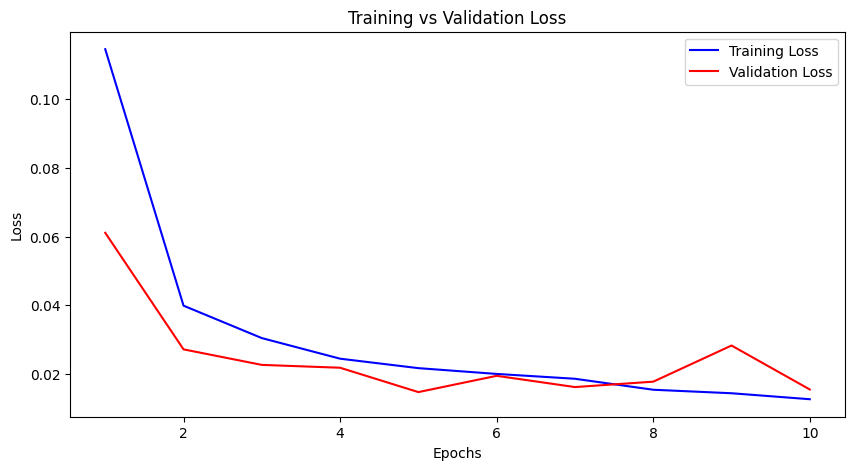

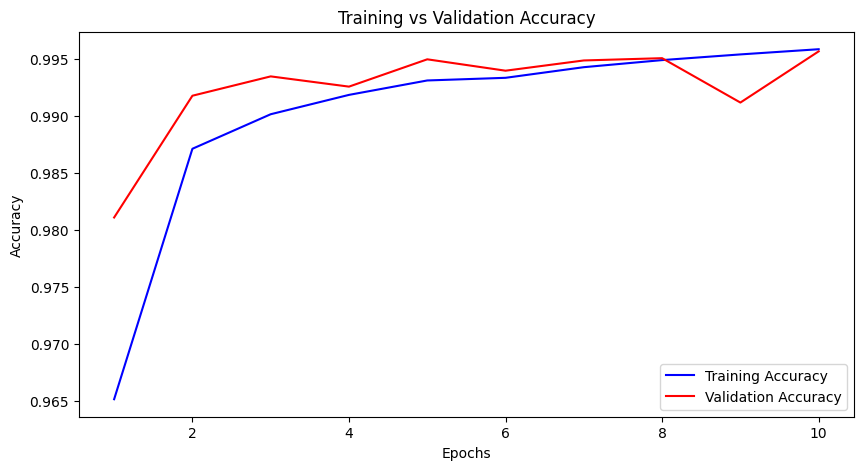

In [12]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)). A [Pytorch tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) shows how to setup the training and validation loop with pytorch.


In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs')

# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



0: adipose
1: background
2: debris
3: lymphocytes
4: mucus
5: smooth muscle
6: normal colon mucosa
7: cancer-associated stroma
8: colorectal adenocarcinoma epithelium


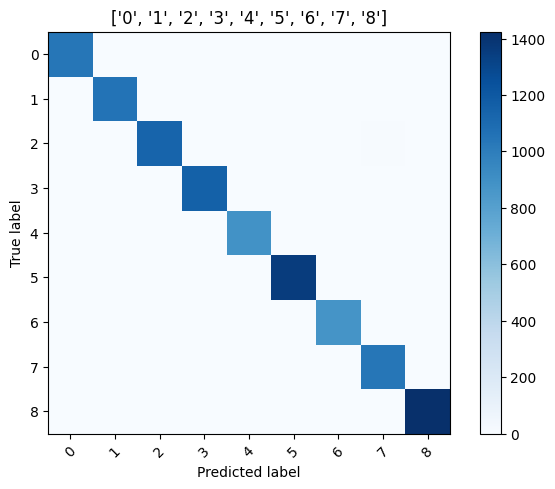

In [14]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
## Collect predictions and true labels from your validation set ## Rafa Code
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        y = torch.squeeze(y)  # shape [N]
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Define class names (PathMNIST has 9 classes)
# classes = list(INFO['pathmnist']['label'].values())
# Keep numerical label since it harder to see the confusion matrix with long label names
classes = [str(i) for i in range(9)]

## End of Rafa code

cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes) # Adding classes

## Printing the labels descriptions to understand Confusion Matrix
from medmnist import INFO

# Get label mapping for PathMNIST
pathmnist_labels = INFO['pathmnist']['label']

# Print the label dictionary
for idx, label in pathmnist_labels.items():
    print(f"{idx}: {label}")

In [15]:
from sklearn.metrics import classification_report
# returning the label name for the Classification Report
classes = list(INFO['pathmnist']['label'].values())
print(classification_report(y_true, y_pred, target_names=classes))

                                      precision    recall  f1-score   support

                             adipose       1.00      1.00      1.00      1041
                          background       1.00      1.00      1.00      1057
                              debris       1.00      0.99      0.99      1152
                         lymphocytes       1.00      1.00      1.00      1156
                               mucus       0.99      0.99      0.99       890
                       smooth muscle       0.99      1.00      1.00      1354
                 normal colon mucosa       1.00      1.00      1.00       877
            cancer-associated stroma       0.99      0.99      0.99      1045
colorectal adenocarcinoma epithelium       1.00      0.99      0.99      1432

                            accuracy                           1.00     10004
                           macro avg       1.00      1.00      1.00     10004
                        weighted avg       1.00      1.00     

 # Comments about your Approach

I chose PathMNIST (RGB, multi-class classification).

**Dataset details:**

- Modality: Colon pathology tissue patches
- Task type: Multi-class classification
- Each image belongs to one of 9 possible tissue classes
- Number of classes: 9
- Channels: 3 (RGB images)
- Samples: 107,180 total
- Training: 89,996
- Validation: 10,004
- Test: 7,180


**Benchmark performance:**

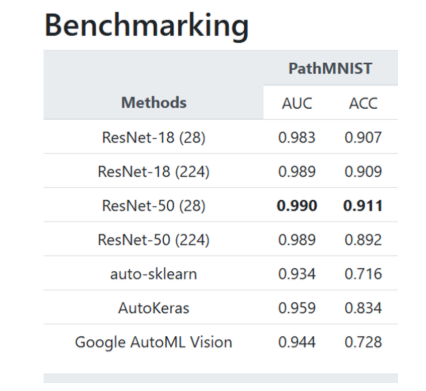![image.png](attachment:image.png)

- Accuracy (ACC) is consistently high (~89.27–91.1%) across ResNet and lower across other methods like AutoML, auto-sklearn, AutoKeras ( ~71.6% - 83.4%).

**Optimisation and training loop approach**

- This is a multi-class problem, where each image is assigned a single label from 9 categories. For the loss function, I am using nn.CrossEntropyLoss(), as suggested by the assignment and since the classes are mutually exclusive.
- I also did a little of Data Augmentation:   v2.RandomHorizontalFlip(), v2.RandomRotation(15).
- The labels come in the shape [N, 1], so I may need to apply torch.squeeze(y) to flatten them into [N] before passing to the loss.
- The model outputs logits of shape [N, 9], and the softmax is applied implicitly inside the loss function.
- I compute the validation loss at the end of every epoch (and could do it more frequently if needed for monitoring).
- For metrics, I am tracking both loss and AUC/ACC, so I can compare my results directly against the published benchmarks.

I can see some pros and cons of using Data Augmentations on PathMNIST dataset, but it is important to notice that I am not expert on this Medical Subject.

**Pros:**

- **Data diversity:**

|- Augmentations increase the effective dataset size, helping the model generalize better.

- **Rotation robustness:**

|- Histopathology images don’t have a fixed orientation — nuclei and tissue structures can appear rotated. Allowing ±15° rotations makes the model less sensitive to orientation.

**Flip robustness:**

|- Horizontal flips can mimic natural variability in tissue slides (since patches can be scanned in different orientations).

**Reduced overfitting:**

|- By exposing the model to slightly altered versions of the same patch, it learns more robust features instead of memorizing training samples.


**Cons:**

**Potential label distortion:**

|- Some medical structures may have orientation‑specific meaning. Excessive flipping or rotation could distort biologically relevant patterns (though ±15° is usually safe).

**Noise introduction:**

|- Augmentations add variability that might not exist in real test data. If overused, they can reduce performance on clean validation/test sets.

**Training instability:**

|- Too much augmentation can slow convergence, requiring more epochs or careful learning rate tuning.

**Flip symmetry assumption:**

|- Horizontal flips assume tissue patterns are symmetric. If certain classes have asymmetric features, flipping could confuse the classifier.


It looks like HOrizontal flip might be generally safe for PathMNIST, if tissue patches don't have strict left/right  orientation.
Rotation(15), might be also safe, since small rotation mimic natural slide variability.


**My Results:**

Confustion Matrix:

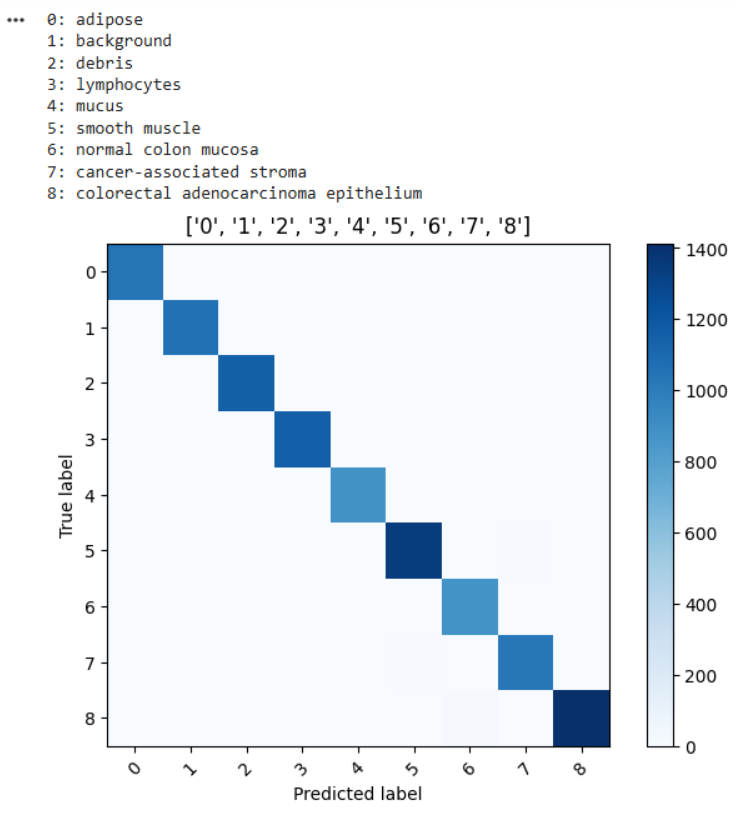

Classification report:

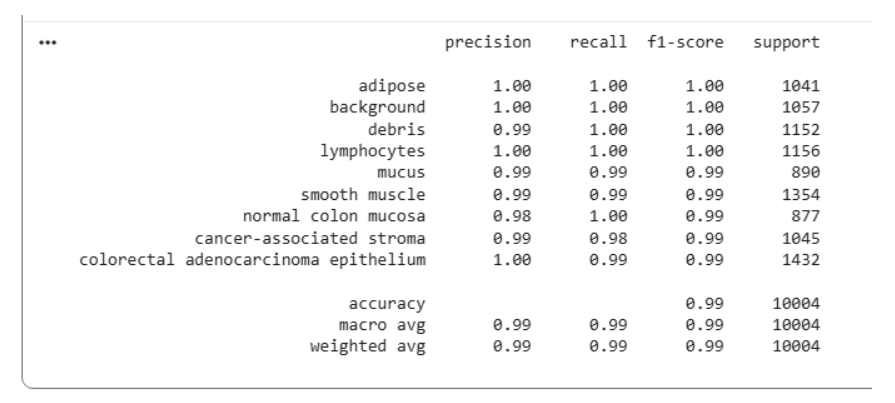



My results showed ~99% accuracy and the official MedMNIST benchmark for PathMNIST reports about 91.1% accuracy.
So, I decided to investigate if there was nothing wrong on my approach.
It was hard to check on other peers, since I guess the majority chose BloodMNIST, with lower dataset. But, I had some ideas and decided to plot trainning vs validation loss/accuracy curves and see if I could validate if my approach was not overfitting.

This is the results:

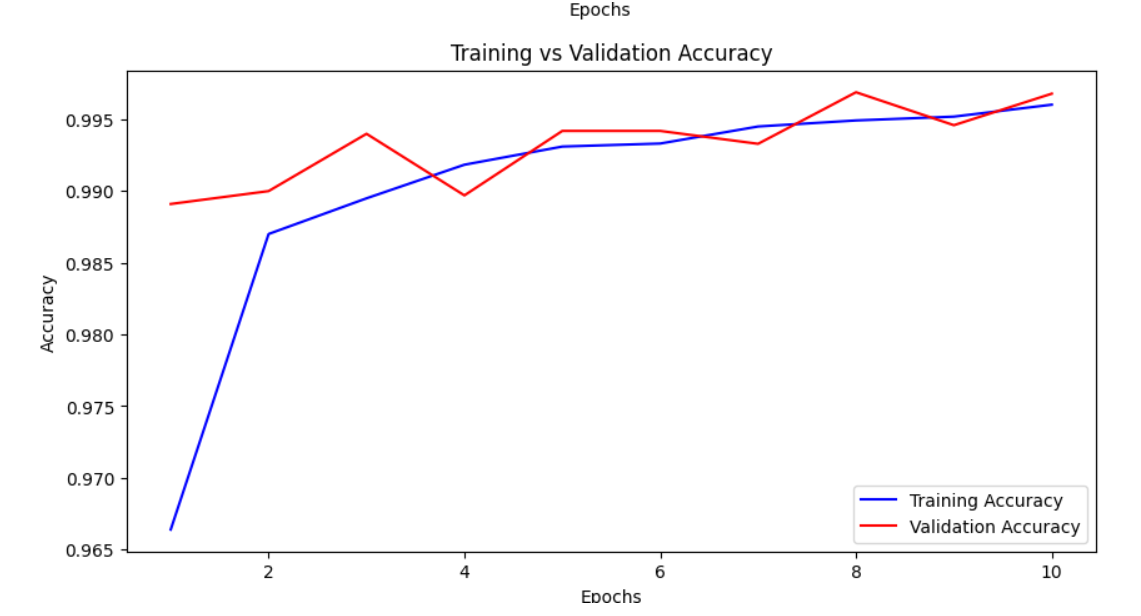![image-4.png](attachment:image-4.png)

- Training Loss steadily decreases across epochs, it seems that model is learning the training data well.
- Validation Loss starts lower than training loss and also decreases, though with slight fluctuations,  this is normal and suggests good generalization.
- No signs of overfitting: Validation loss doesn’t spike or diverge from training loss.
- No signs of underfitting: Both losses are low and decreasing, which means the model is capturing meaningful patterns.

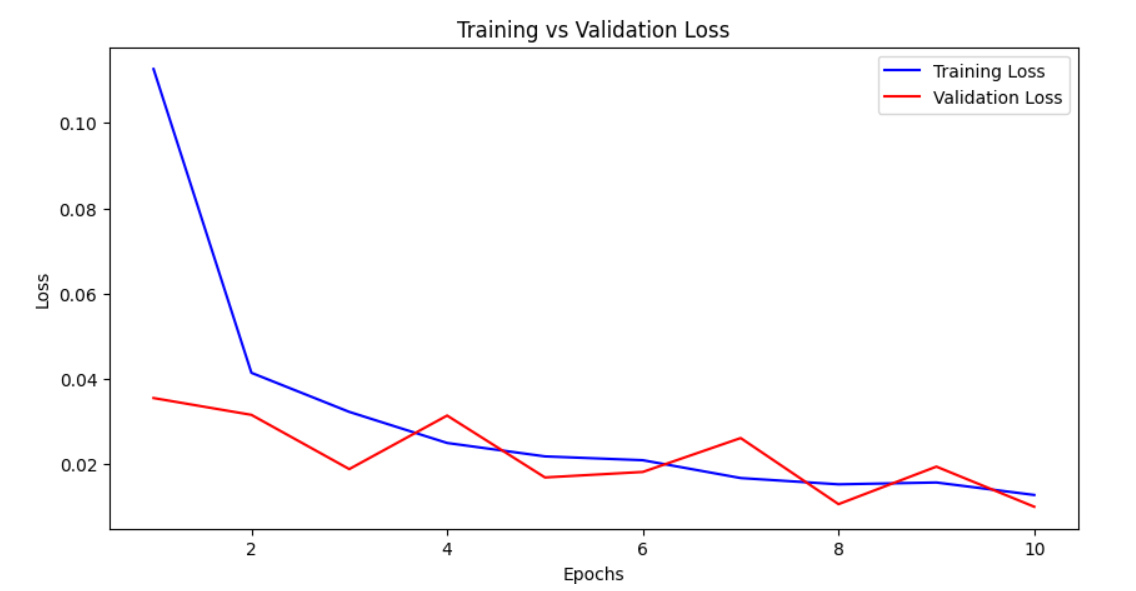![image-5.png](attachment:image-5.png)

- **Training Accuracy **steadily increases and reaches near-perfect levels by epoch 10.

- **Validation Accuracy** fluctuates slightly but remains consistently high — above 96.5% throughout.

- The gap between training and validation accuracy is minimal, in my opinion.

I think that curves suggests that my model is not underfitting — It is learning effectively and generalizing well.

It’s also not overfitting — validation accuracy doesn’t collapse or diverge.

I guess that the high performance across both curves suggests my pipeline is well-tuned for PathMNIST.